Take home assessment: Prediction of bank statement

In [46]:
import numpy 
import pandas
import tensorflow
import matplotlib.pyplot as pyplot
import pickle
import seaborn
from transformers import TFBertModel,BertTokenizer,TFBertForSequenceClassification,AdamWeightDecay
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

Importing CSV and Json

In [ ]:
# Loading CSVs and Json config
banktranscsv: pandas.DataFrame = pandas.read_csv("csv/bank_transaction.csv")
userprofilecsv: pandas.DataFrame = pandas.read_csv("csv/user_profile.csv")

# Copy both dataset to prevent tempering with original dataset
userprofiledf: pandas.DataFrame = userprofilecsv.copy()
banktransfiledf: pandas.DataFrame = banktranscsv.copy()

# Convert the columns lowercase for consistency
userprofiledf.columns = userprofiledf.columns.str.lower()
banktransfiledf['description'] = banktransfiledf['description'].str.lower()

# Convert behaviour to binary from True/False 
behaviour = userprofiledf.columns[1:]
for column in behaviour:userprofiledf[column] = userprofiledf[column].astype(int)


# Merge both datasets with "client_id" being the primary key
mergeddf: pandas.DataFrame = pandas.merge(banktransfiledf, userprofiledf, on="client_id", how="left")

# filling empty columns categoies with "uncategorized" in merged dataset 
mergeddf['category'] = mergeddf['category'].fillna('uncategorized')


(80:20) test split for training based on description, category, userbheaviour

In [ ]:
x = mergeddf['description']
y = mergeddf['category']
userbehaviour = mergeddf[['is_interested_investment','is_interested_build_credit','is_interested_increase_income','is_interested_pay_off_debt','is_interested_manage_spending','is_interested_grow_savings']]
x_train,x_test,y_train,y_test,userbehaviour_train,userbehaviour_test = train_test_split(x,y,userbehaviour, test_size = 0.2, random_state = 42, stratify=y)

Saving Embedded for userbehaviour train and test 

In [41]:
# Converting to numpy to save later
userbehaviourtrain = userbehaviour_train.to_numpy()
userbehaviourtest = userbehaviour_test.to_numpy()

# Save the Files
numpy.save("embeddings/userbehaviourtrain.npy", userbehaviourtrain)
numpy.save("embeddings/userbehaviourtest.npy", userbehaviourtest)

Setting up BERT Model for training

In [5]:
# Loading Bert with classification 
Bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)))
Berttokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize data
encodingTraindata = Berttokenizer(list(x_train), truncation=True, padding=True, return_tensors="tf")
encodingTestdata = Berttokenizer(list(x_test), truncation=True, padding=True, return_tensors="tf")

# Label Encoding
labelencoder = LabelEncoder()
y_trainencoded = labelencoder.fit_transform(y_train)
y_testencoded = labelencoder.transform(y_test)

# Converting the labels to tensors
y_trainencoded = tensorflow.convert_to_tensor(y_trainencoded ,dtype = tensorflow.int32)
y_testencoded = tensorflow.convert_to_tensor(y_testencoded, dtype = tensorflow.int32)

# Dataset setup
traindataset = tensorflow.data.Dataset.from_tensor_slices((dict(encodingTraindata), y_trainencoded)).batch(11)
testdataset =  tensorflow.data.Dataset.from_tensor_slices((dict(encodingTestdata), y_testencoded)).batch(11)

# Model Setup for training
adamoptimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)
Bert.compile(optimizer=adamoptimizer, loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics=['accuracy'])
BertTelemetry = Bert.fit(traindataset,validation_data=testdataset, epochs=6)


# Save the model
Bert.save_pretrained('traininghistory/bertfinetuned')
Bert.save_weights("traininghistory/bertfinetuned/tf_model.h5")
Berttokenizer.save_pretrained('traininghistory/bertfinetuned')



I0000 00:00:1742323679.802404   12317 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:07:00.0, compute capability: 8.9
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
18821/18821 [==============================] - 3031s 160ms/step - loss: 0.5452 - accuracy: 0.8278 - val_loss: 0.3877 - val_accuracy: 0.8616
Epoch 2/6
18821/18821 [==============================] - 3013s 160ms/step - loss: 0.3426 - accuracy: 0.8747 - val_loss: 0.3432 - val_accuracy: 0.8720
Epoch 3/6
18821/18821 [==============================] - 2994s 159ms/step - loss: 0.2936 - accuracy: 0.8885 - val_loss: 0.3277 - val_accuracy: 0.8803
Epoch 4/6
18821/18821 [==============================] - 2992s 159ms/step - loss: 0.2673 - accuracy: 0.8968 - val_loss: 0.3248 - val_accuracy: 0.8832
Epoch 5/6
18821/18821 [==============================] - 2992s 159ms/step - loss: 0.2509 - accuracy: 0.9022 - val_loss: 0.3232 - val_accuracy: 0.8853
Epoch 6/6
18821/18821 [==============================] - 2986s 159ms/step - loss: 0.2398 - accuracy: 0.9061 - val_loss: 0.3177 - val_accuracy: 0.8865


('traininghistory/bertfinetuned/tokenizer_config.json',
 'traininghistory/bertfinetuned/special_tokens_map.json',
 'traininghistory/bertfinetuned/vocab.txt',
 'traininghistory/bertfinetuned/added_tokens.json')

Saving Telemtry of Bert for asessment

In [ ]:
with open('traininghistory/bert/bert_training_history.pkl', 'wb') as file:
    pickle.dump(BertTelemetry.history, file)

print(f"Final loss: {BertTelemetry.history['loss'][-1]:.4f}")
print(f"Final accuracy: {BertTelemetry.history['accuracy'][-1]:.4f}")

Final loss: 0.2398
Final accuracy: 0.9061


Extract embedding using CLS token

In [10]:
# Load the fine-tuned BERT model and tokenizer from the specified path
finetunedbert = TFBertModel.from_pretrained('traininghistory/bertfinetuned')
finetunedtokenizer = BertTokenizer.from_pretrained('traininghistory/bertfinetuned')

# Function to extract embedding from fine-tuned bert in batches
def get_finetuned_bert_embedding_batched(texts, batch_size=11):
    all_embeddings = []
    
    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Show progress
        if i % (batch_size * 100) == 0:
            print(f"Processing batch {i//batch_size + 1}/{len(texts)//batch_size + 1}")
            
        # Use your fine-tuned tokenizer and model
        encoded_input = finetunedtokenizer(batch_texts, truncation=True, padding=True, return_tensors="tf")
        output = finetunedbert(encoded_input["input_ids"], attention_mask=encoded_input["attention_mask"])
        batch_embeddings = output.last_hidden_state[:, 0, :].numpy()
        
        all_embeddings.append(batch_embeddings)
    
    # Combine all batch results
    return numpy.vstack(all_embeddings)


# Process training data
Xtrain_embeddings = get_finetuned_bert_embedding_batched(list(x_train))

# Process test data
Xtest_embeddings = get_finetuned_bert_embedding_batched(list(x_test))

# Save them into files
numpy.save("embeddings/xtrainembeddings.npy", Xtrain_embeddings)
numpy.save("embeddings/xtestembeddings.npy", Xtest_embeddings)
numpy.save("embeddings/ytrainencoded.npy", y_trainencoded)
numpy.save("embeddings/ytestencoded.npy", y_testencoded)

print("Done saving embeddings")

Some layers from the model checkpoint at traininghistory/bertfinetuned were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at traininghistory/bertfinetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Processing batch 1/18821
Processing batch 101/18821
Processing batch 201/18821
Processing batch 301/18821
Processing batch 401/18821
Processing batch 501/18821
Processing batch 601/18821
Processing batch 701/18821
Processing batch 801/18821
Processing batch 901/18821
Processing batch 1001/18821
Processing batch 1101/18821
Processing batch 1201/18821
Processing batch 1301/18821
Processing batch 1401/18821
Processing batch 1501/18821
Processing batch 1601/18821
Processing batch 1701/18821
Processing batch 1801/18821
Processing batch 1901/18821
Processing batch 2001/18821
Processing batch 2101/18821
Processing batch 2201/18821
Processing batch 2301/18821
Processing batch 2401/18821
Processing batch 2501/18821
Processing batch 2601/18821
Processing batch 2701/18821
Processing batch 2801/18821
Processing batch 2901/18821
Processing batch 3001/18821
Processing batch 3101/18821
Processing batch 3201/18821
Processing batch 3301/18821
Processing batch 3401/18821
Processing batch 3501/18821
Proc

XGBoost optimized with GridSearch encoporating with user financial behaviour 

In [ ]:
# Loading embeddings
X_trainembeddings = numpy.load("embeddings/xtrainembeddings.npy")
X_testembeddings = numpy.load("embeddings/xtestembeddings.npy")
y_trainencoded = numpy.load("embeddings/ytrainencoded.npy")
y_testencoded = numpy.load("embeddings/ytestencoded.npy")
userbehaviour_train = numpy.load("embeddings/userbehaviourtrain.npy")
userbehaviour_test = numpy.load("embeddings/userbehaviourtest.npy")

#Concat embeddings for XGBoost training
X_trainembeddings = numpy.concatenate((X_trainembeddings, userbehaviour_train), axis=1)
X_testembeddings = numpy.concatenate((X_testembeddings, userbehaviour_test), axis=1)

# Gridsearch Parameters
parameters = {
    'learning_rate': [0.1],  
    'n_estimators': [500],  
    'max_depth': [6,10],  
    'subsample': [0.8],  
    'colsample_bytree': [0.8],  
    'gamma': [0], 
}

# Model Setup with extracting telemetry
XGB = XGBClassifier(eval_metric='mlogloss', tree_method='hist', device = "cuda")

# Setting up GridSearch Tuning
gridsearchoptimization = GridSearchCV(XGB, parameters, n_jobs=1, cv=3, verbose=3)
gridsearchtelemetry = gridsearchoptimization.fit(X_trainembeddings, y_trainencoded)

finetunedxgb = gridsearchoptimization.best_estimator_
bestparameter = gridsearchoptimization.best_params_

prediction = finetunedxgb.predict(X_testembeddings)

# Getting Telemetry from xgboost
xgbaccurary = accuracy_score(y_testencoded, prediction)
xgbclassificationreport = classification_report(y_testencoded, prediction, zero_division= 0, output_dict=True )
xgbconfusionmatrix = confusion_matrix(y_testencoded, prediction)

# Converting the telemetry into DataFrame 
classificationreport = pandas.DataFrame(xgbclassificationreport).transpose()
confusionmatrix = pandas.DataFrame(xgbconfusionmatrix)
bestparams = pandas.DataFrame([bestparameter])

# Saving the DataFrame into CSVs to plot the graph later
classificationreport.to_csv('traininghistory/XGBoost/fused_classification_report.csv', index=True)
confusionmatrix.to_csv('traininghistory/XGBoost/fused_confusion_matrix.csv', index=True)
bestparams.to_csv('traininghistory/XGBoost/fused_best_parameters.csv', index=True)

#Save Model
with open('XGBoostTuned/fusedxgboost_model.pkl', 'wb') as model_file:
    pickle.dump(finetunedxgb, model_file)

print (f"Accuracy: {xgbaccurary:.2f}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/user/miniconda3/envs/tensorflow/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [21:43:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8;, score=0.909 total time= 3.6min
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8;, score=0.912 total time= 3.1min
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8;, score=0.913 total time= 3.1min
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8;, score=0.907 total time= 5.3min
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8;, score=0.910 total time= 5.3min
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.8;, score=0.912 total time= 4.9min
Accuracy: 0.89


Best Parameter For XGBoost Model

In [24]:
bestparameter

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 500,
 'subsample': 0.8}

Performance visualization of the models


Bert

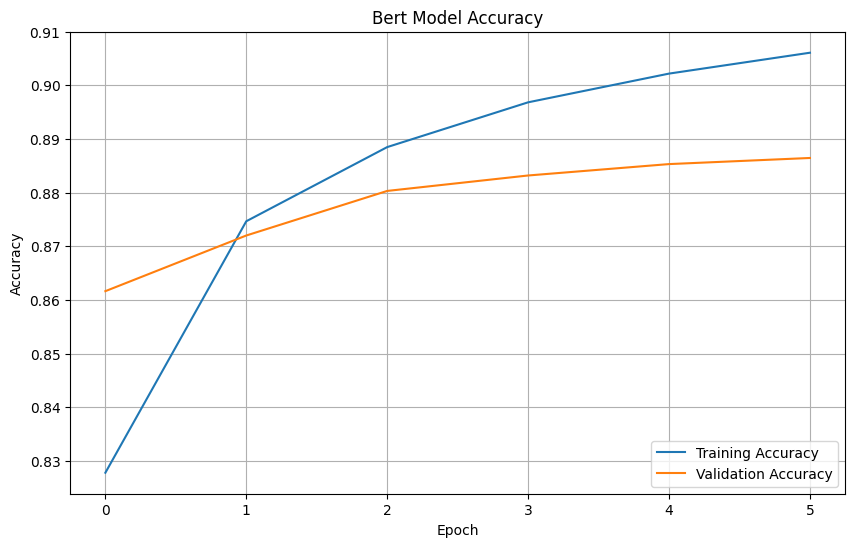

In [18]:
# Load the history dictionary from pickle file
BertTrainHistory = pickle.load(open('traininghistory/bert/bert_training_history.pkl', 'rb'))

# Create the plot
pyplot.figure(figsize=(10, 6))
pyplot.plot(BertTrainHistory['accuracy'], label='Training Accuracy')
pyplot.plot(BertTrainHistory['val_accuracy'], label='Validation Accuracy')
pyplot.title('Bert Model Accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(loc='lower right')
pyplot.grid(True)

# Display the plot
pyplot.show()

XGBoost

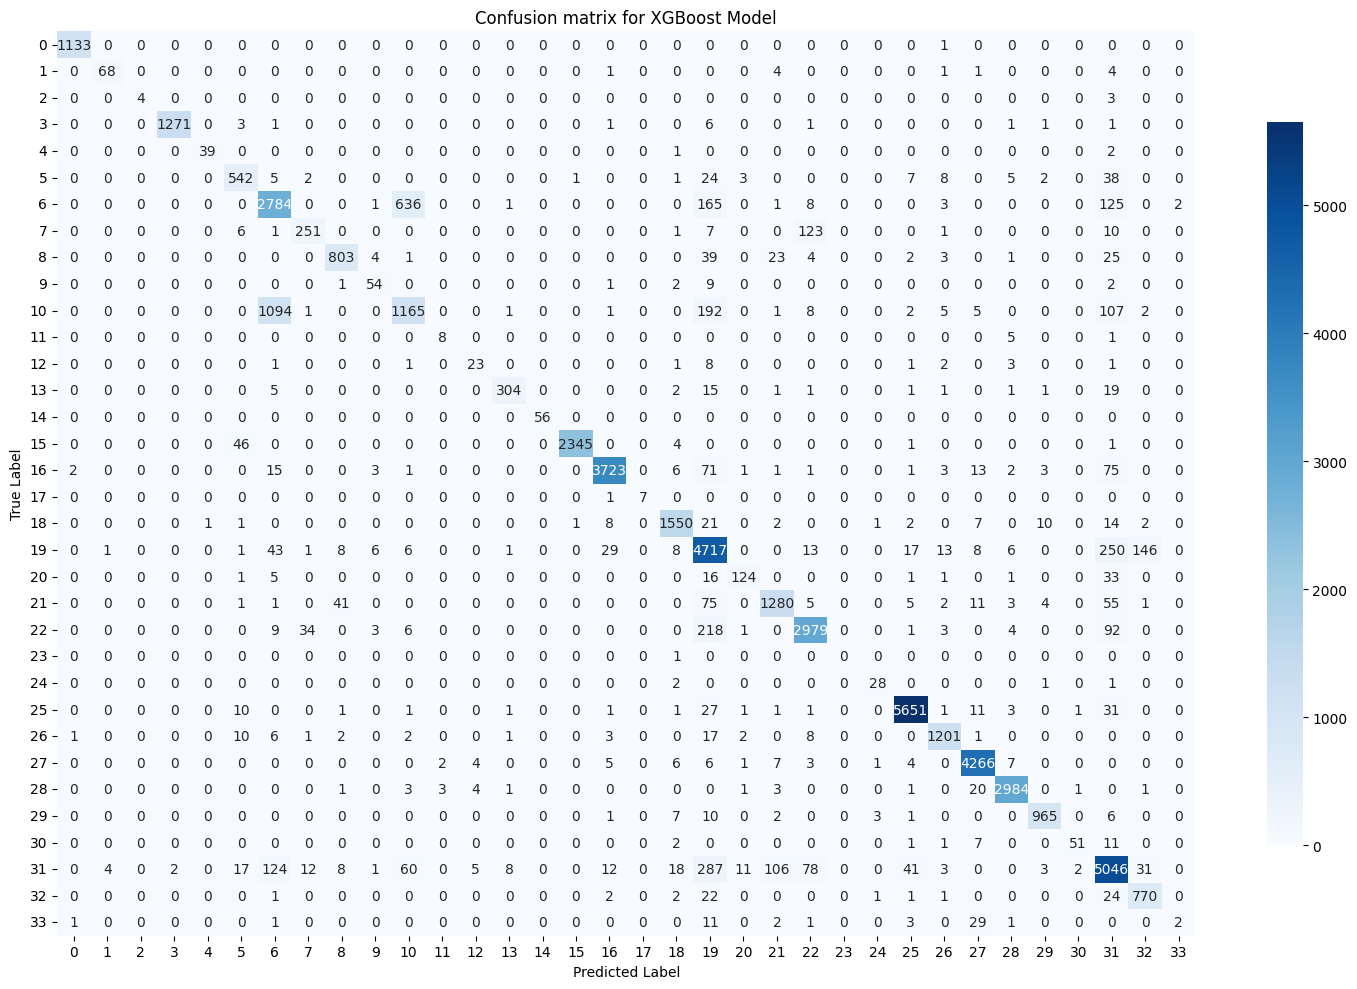

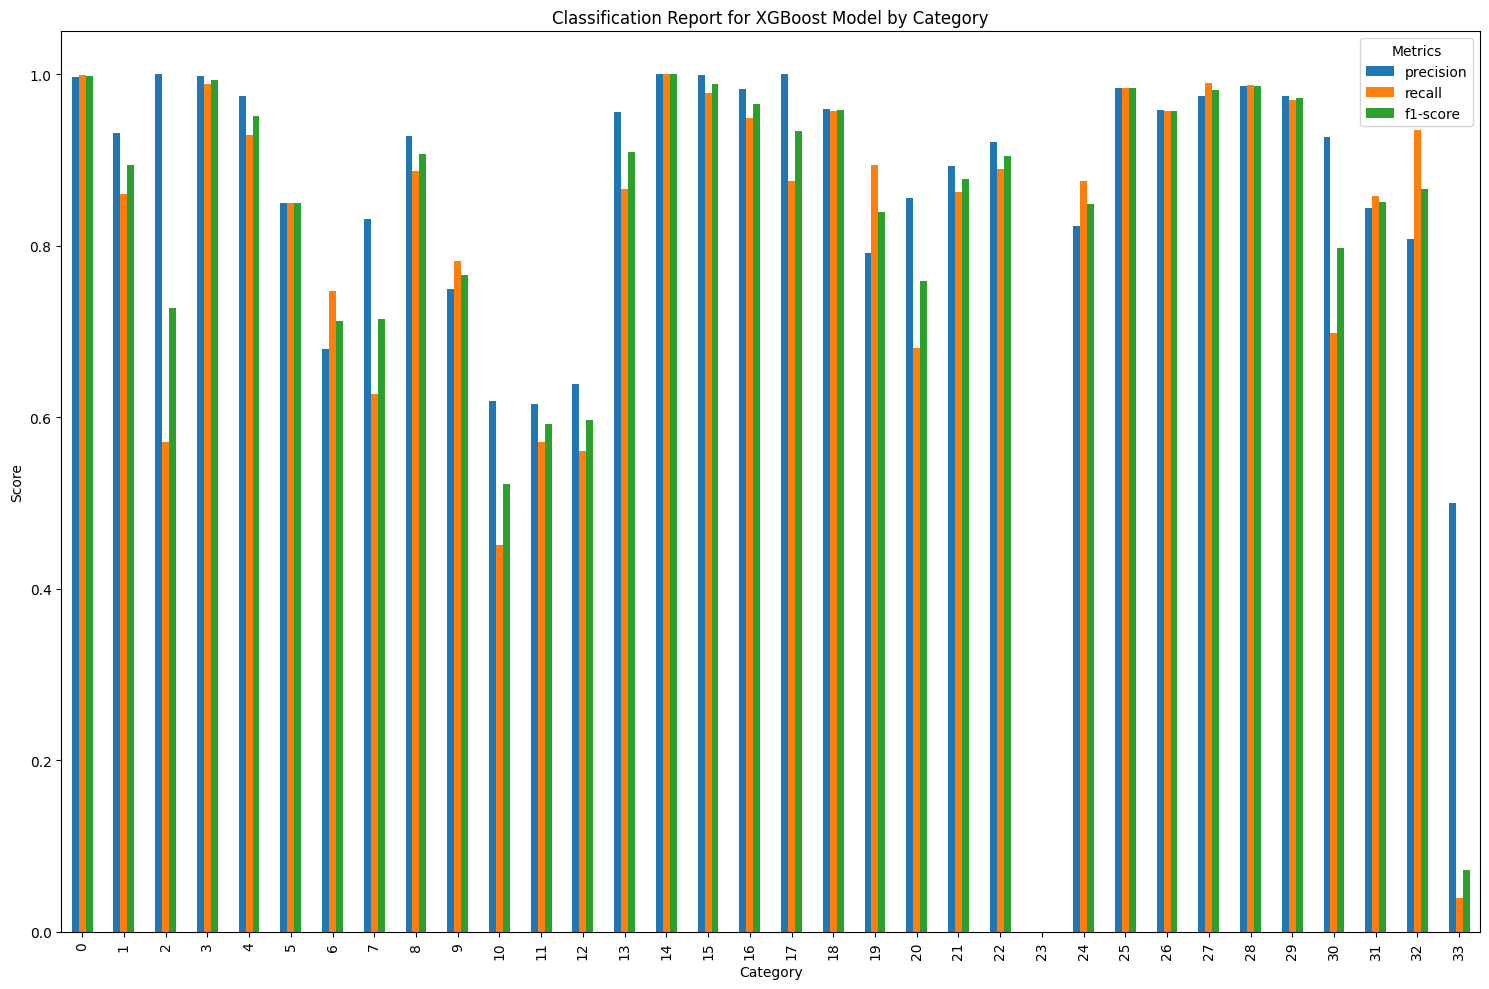

,precision,recall,f1-score,support
0,0.996482,0.999118,0.997798,1134.000000
1,0.931507,0.860759,0.894737,79.000000
2,1.000000,0.571429,0.727273,7.000000
3,0.998429,0.988336,0.993357,1286.000000
4,0.975000,0.928571,0.951220,42.000000
5,0.849530,0.849530,0.849530,638.000000
6,0.679688,0.747182,0.711838,3726.000000
7,0.831126,0.627500,0.715100,400.000000
8,0.928324,0.887293,0.907345,905.000000
9,0.750000,0.782609,0.765957,69.000000


In [48]:
# Loading csv for displaying datas of the model
confusionmatrix = pandas.read_csv('traininghistory/XGBoost/fused_confusion_matrix.csv', index_col=0)
classification = pandas.read_csv('traininghistory/XGBoost/fused_classification_report.csv', index_col=0)


# Confusion Matrix 
pyplot.figure(figsize=(15, 10))
seaborn.heatmap(confusionmatrix, annot=True, fmt="g", cmap="Blues",cbar_kws={'shrink': 0.8})
pyplot.title('Confusion matrix for XGBoost Model')
pyplot.ylabel('True Label')
pyplot.xlabel('Predicted Label')
pyplot.yticks(rotation=0)
pyplot.tight_layout()
pyplot.show()

# Classification Report
# Adjust the column names if necessary.
metrics = ['precision', 'recall', 'f1-score']
class_rows = classification.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
class_rows[metrics].plot(kind='bar', figsize=(15, 10))
pyplot.title('Classification Report for XGBoost Model by Category')
pyplot.xlabel('Category')
pyplot.ylabel('Score')
pyplot.legend(title='Metrics')
pyplot.xticks(rotation=90)  
pyplot.tight_layout()
pyplot.show()

# Print the classification values
classification
